# Proccess Samples
This script takes raw measurement data, and spits out a "master data" spreadsheet with all data organized and including both raw and dip-adjusted depths

## Import Packages

In [194]:
# general
import numpy as np
import pandas as pd


# plotting
import matplotlib.pyplot as plt

## Setup

In [195]:
# Set filepaths

path_to_data = '../../data/'
path_to_figures = '../../../figures/'

## Load Dip Data

In [196]:
angles = pd.read_csv(path_to_data + 'angles/angles.csv')
angles.head()

,core,section,ACorDC,top_angle,left_angle,right_angle,side_angle,true_dip,true_dip_angles,true_dip_scores
0,alhic1901,228_4,AC,-36.776051,16.199769,-10.606322,13.403045,-38.643013,[-38.87808981 -38.54424142 -39.18075393 -37.73...,[0.88933205 0.97882252 0.95474921 0.95895482 0...
1,alhic1901,230_4,AC,27.819776,30.749623,-30.156336,30.452979,38.799076,[36.94242001 34.92239342 34.74296877 37.507310...,[0.99150915 0.99005042 0.99079277 0.99085791 0...


## Make some functions

In [ ]:
# preform dip adjustment
def dip_adjust(angles,data):

    # pull out angle 
    #top_angle = angles.loc[angles['section'] == data.iloc[0]['section'], 'top_angle'].values[0]
    #side_angle = angles.loc[angles['section'] == data.iloc[0]['section'], 'side_angle'].values[0]

    # Add 'top_angle' and 'side_angle' columns to data
    data['top_angle'] = data['section'].map(
        lambda sec: angles.loc[angles['section'] == sec, 'top_angle'].values[0]
    )
    data['side_angle'] = data['section'].map(
        lambda sec: angles.loc[angles['section'] == sec, 'side_angle'].values[0]
    )

    # make new depth columns
    data['top_depth_adj'] = data['top_depth'] + (
        data['effective_center_x'] * np.tan(data['top_angle'] * np.pi / 180) +
        data['effective_center_y'] * np.tan(data['side_angle'] * np.pi / 180))/1000
    data['bottom_depth_adj'] = data['bottom_depth'] + (
        data['effective_center_x'] * np.tan(data['top_angle'] * np.pi / 180) +
        data['effective_center_y'] * np.tan(data['side_angle'] * np.pi / 180))/1000
    data['mid_depth_adj'] = data['mid_depth'] + (
        data['effective_center_x'] * np.tan(data['top_angle'] * np.pi / 180) +
        data['effective_center_y'] * np.tan(data['side_angle'] * np.pi / 180))/1000

    return (data)

In [205]:
# simple before/after plot
def simple_plot(data,prox,path_to_figures,dtype):

    # pull out unique values in data['section']
    sections = data['section'].unique()

    # make a set of colors for plot lines using colormap
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i) for i in range(len(data['stick'].unique()))]

    # make a plot for each core section
    for sec in sections:

        # filter for data in section
        df_sec = data.loc[data['section'] == sec]

        # new figure
        fig, ax = plt.subplots(len(prox), 2, figsize=(12, 6))
        fig.suptitle('Section ' + str(sec))

        # new row for each proxy
        for i in range(len(prox)):

            # pull out data for this stick
            sticks = data['stick'].unique()

            # new line for each stic
            for j in range(len(sticks)):
                stick = sticks[j]

                # pull out data for this stick
                df = df_sec.loc[df_sec['stick'] == stick]

                if len(df) == 0:
                    break

                # plot the data
                ax[i,0].plot(df['mid_depth'],df[prox[i]],color=colors[j],label=stick)
                ax[i,1].plot(df['mid_depth_adj'],df[prox[i]],color=colors[j],label=stick)

                # add labels
                ax[i,0].set_ylabel(prox[i])
                ax[i,1].set_ylabel(prox[i])
                ax[i,0].set_xlabel('Depth (m)')
                ax[i,1].set_xlabel('Depth (m)')
                ax[i,0].set_title(prox[i]+' - Before Dip Adjustment')
                ax[i,1].set_title(prox[i]+' - After Dip Adjustment')

                # add legend
                ax[i,0].legend(fontsize=8)

        plt.tight_layout()
        fig.show()
        
        fig.savefig(path_to_figures + 'initial_dip_adjustment/' + dtype+'-'+ str(sec) + '.png', dpi=300)
                



In [ ]:
## Let's do ECM data first

## Step 1 - Water Isotopes

In [206]:
# load water isotope data
water_iso_data = pd.read_excel(path_to_data + '/sampling/water_iso/water_iso_data.xlsx')
water_iso_data.head()

,section,stick,top_depth,bottom_depth,mid_depth,dD,d17O,d18O,dxs
0,228_4,l_iso,155.0650,155.0750,155.0700,-296.18,-19.70,-37.03,0.07
1,228_4,l_iso,155.0761,155.0861,155.0811,-295.74,-19.69,-36.96,-0.05
2,228_4,l_iso,155.0873,155.0973,155.0923,-295.99,-19.72,-37.05,0.40
3,228_4,l_iso,155.0984,155.1084,155.1034,-296.24,-19.80,-37.22,1.49
4,228_4,l_iso,155.1095,155.1195,155.1145,-296.55,-19.90,-37.40,2.62


In [207]:
# load water isotope metadata

water_iso_metadata = pd.read_excel(path_to_data + '/sampling/water_iso/water_iso_metadata.xlsx')
water_iso_metadata.head()

,section,stick,x_lo,x_hi,y_lo,y_hi
0,230_4,l_iso,103,113,0,32
1,230_4,r_iso,60,83,72,92
2,228_4,c_iso,-15,15,-100,-115
3,228_4,l_iso,-110,-120,0,30
4,228_4,r_iso,120,100,0,30


In [208]:
# add metadata to water isotope data
# Merge water isotope data with metadata based on matching 'section' and 'Stick' columns
# Perform a manual merge using a loop
metadata_dict = water_iso_metadata.set_index(['section', 'stick']).to_dict(orient='index')

# Add metadata columns to water_iso_data
for idx, row in water_iso_data.iterrows():
    key = (row['section'], row['stick'])
    if key in metadata_dict:
        for col, value in metadata_dict[key].items():
            water_iso_data.at[idx, col] = value

# add columns for effective center
water_iso_data['effective_center_x'] = (water_iso_data['x_lo'] + water_iso_data['x_hi'])/2
water_iso_data['effective_center_y'] = (water_iso_data['y_lo'] + water_iso_data['y_hi'])/2

water_iso_data.head()

,section,stick,top_depth,bottom_depth,mid_depth,dD,d17O,d18O,dxs,x_lo,x_hi,y_lo,y_hi,effective_center_x,effective_center_y
0,228_4,l_iso,155.0650,155.0750,155.0700,-296.18,-19.70,-37.03,0.07,-110.0,-120.0,0.0,30.0,-115.0,15.0
1,228_4,l_iso,155.0761,155.0861,155.0811,-295.74,-19.69,-36.96,-0.05,-110.0,-120.0,0.0,30.0,-115.0,15.0
2,228_4,l_iso,155.0873,155.0973,155.0923,-295.99,-19.72,-37.05,0.40,-110.0,-120.0,0.0,30.0,-115.0,15.0
3,228_4,l_iso,155.0984,155.1084,155.1034,-296.24,-19.80,-37.22,1.49,-110.0,-120.0,0.0,30.0,-115.0,15.0
4,228_4,l_iso,155.1095,155.1195,155.1145,-296.55,-19.90,-37.40,2.62,-110.0,-120.0,0.0,30.0,-115.0,15.0


In [209]:
# preform dip adjustment
water_iso_master = dip_adjust(angles,water_iso_data)

# save data
water_iso_master.to_csv(path_to_data + 'sampling/master/water_iso_master.csv', index=False)

water_iso_master.head()

,section,stick,top_depth,bottom_depth,mid_depth,dD,d17O,d18O,dxs,x_lo,x_hi,y_lo,y_hi,effective_center_x,effective_center_y,top_depth_adj,bottom_depth_adj,mid_depth_adj
0,228_4,l_iso,155.0650,155.0750,155.0700,-296.18,-19.70,-37.03,0.07,-110.0,-120.0,0.0,30.0,-115.0,15.0,155.15453,155.16453,155.15953
1,228_4,l_iso,155.0761,155.0861,155.0811,-295.74,-19.69,-36.96,-0.05,-110.0,-120.0,0.0,30.0,-115.0,15.0,155.16563,155.17563,155.17063
2,228_4,l_iso,155.0873,155.0973,155.0923,-295.99,-19.72,-37.05,0.40,-110.0,-120.0,0.0,30.0,-115.0,15.0,155.17683,155.18683,155.18183
3,228_4,l_iso,155.0984,155.1084,155.1034,-296.24,-19.80,-37.22,1.49,-110.0,-120.0,0.0,30.0,-115.0,15.0,155.18793,155.19793,155.19293
4,228_4,l_iso,155.1095,155.1195,155.1145,-296.55,-19.90,-37.40,2.62,-110.0,-120.0,0.0,30.0,-115.0,15.0,155.19903,155.20903,155.20403


In [211]:
water_iso_master['effective_center_y'].unique()

array([  15. , -107.5,   16. ,   82. ])

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_7775/2230037596.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


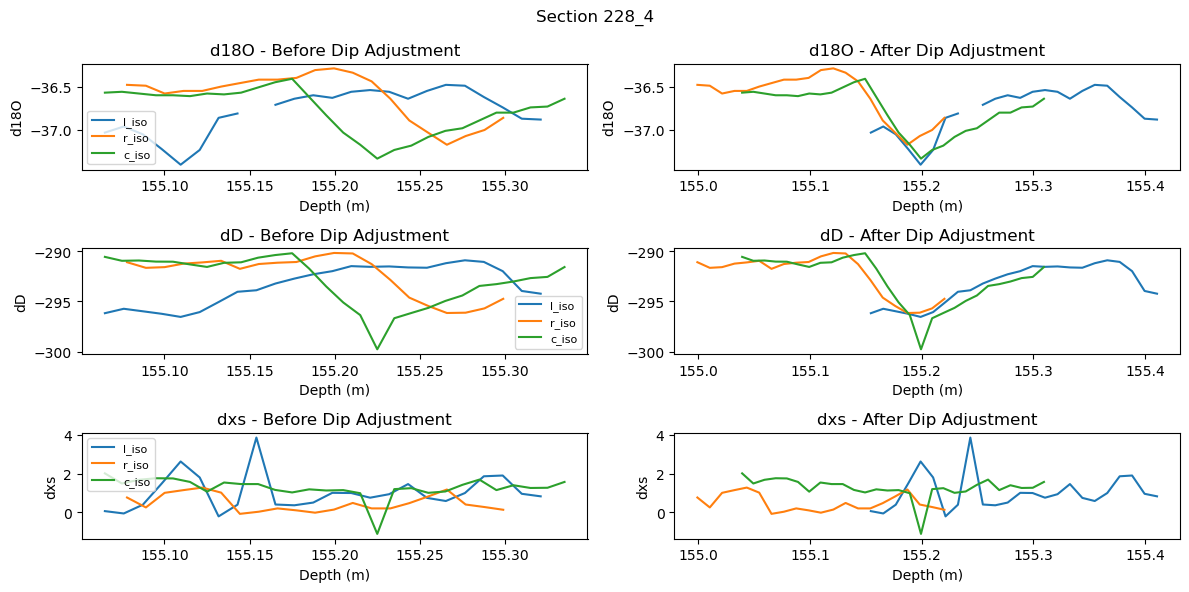

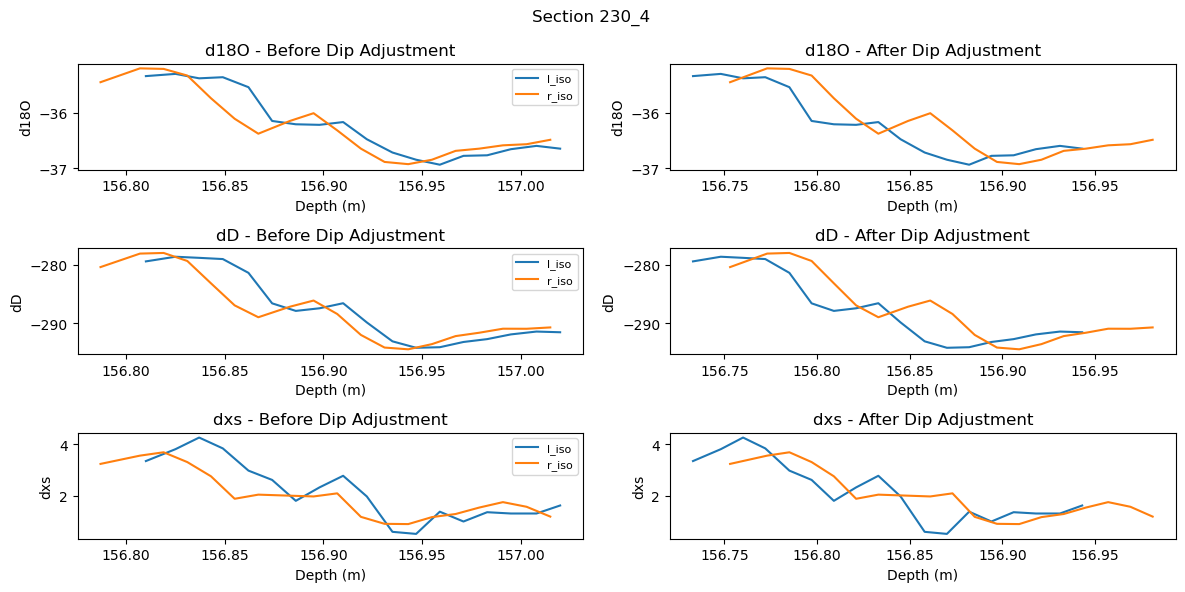

In [203]:
simple_plot(water_iso_data,['d18O','dD','dxs'],path_to_figures,'water_iso')

## Let's make a diagnostic plot for tilting



In [204]:
# load the ECM data
